In [1]:
# # For Google Colab
# # Mount GDrive
# from google.colab import drive

# drive.mount("/content/drive")

In [2]:
# # For Google Colab
# # Put Colab in the context of this challenge
# import os

# # os.chdir allows you to change directories, like cd in the Terminal
# os.chdir("/content/drive/MyDrive/Colab Notebooks/CXRay/notebooks")

# Data Pre-Processing

In [23]:
import os
import pathlib

import pandas as pd

In [24]:
cwd = os.getcwd()
data_path = pathlib.Path(cwd, "..", "clean_data", "cleaned_data.csv")

data = pd.read_csv(data_path)
data.head()

,img_idx,labels,age,gender,view_pos,label_cardiomegaly,label_effusion,label_no_finding,label_pneumothorax,label_pleural_thickening,label_pneumonia,label_consolidation,label_other
0,00000001_000.png,Cardiomegaly,58,M,PA,True,False,False,False,False,False,False,False
1,00000001_001.png,Cardiomegaly|Emphysema,58,M,PA,True,False,False,False,False,False,False,True
2,00000001_002.png,Cardiomegaly|Effusion,58,M,PA,True,True,False,False,False,False,False,False
3,00000002_000.png,No Finding,81,M,PA,False,False,True,False,False,False,False,False
4,00000003_000.png,Hernia,81,F,PA,False,False,False,False,False,False,False,True


In [25]:
# data = data.drop(columns="label_other")
data = data.drop(columns="label_no_finding")
data.shape

(112104, 12)

In [6]:
# # For Google Colab
# def is_uploaded(filename: str) -> bool:
#     filepath = str(pathlib.Path(cwd, "..", "raw_data", "images_224_224", filename))
#     if os.path.exists(filepath):
#         return os.stat(filepath).st_size != 0
#     return False

# data["image_is_uploaded"] = data.img_idx.apply(lambda x: is_uploaded(x))
# data = data[data.image_is_uploaded]
# data.shape

In [26]:
label_names = [l for l in data.columns if l.startswith("label_")]
label_names

['label_cardiomegaly',
 'label_effusion',
 'label_pneumothorax',
 'label_pleural_thickening',
 'label_pneumonia',
 'label_consolidation',
 'label_other']

In [27]:
label_counts_sorted = data[label_names].sum(axis=0).sort_values()
label_counts_sorted

label_pneumonia              1430
label_cardiomegaly           2776
label_pleural_thickening     3384
label_consolidation          4667
label_pneumothorax           5301
label_effusion              13316
label_other                 39770
dtype: int64

We want to have a balanced dataset that contains an equal number of examples of each condition (+"no finding"), regardless of 'overlaps' (i.e. multiple conditions).  

We will start from the lowest common denominator, i.e. the condition with the fewest number of examples, i.e. pnemonia. We will choose **all** of the pneumonia cases, `N0 = N_pneumonia = 1430` above. Then we have to choose the same number of examples from each of the other conditions, in increasing order of the number of cases. But there are overlaps, so we will exclude cases already chosen from previous labels (i.e. those with fewer examples). We will keep adding examples until we have `N0` rows with each label.

In [28]:
rarest_label = label_counts_sorted.index[0]
rarest_label_count = data[data[rarest_label]].shape[0]
data_balanced = data[data[rarest_label]]
n_min = data_balanced.shape[0]
for label, count in zip(label_counts_sorted.index[1:], label_counts_sorted[1:]):
    n_already_captured = data_balanced[data_balanced[label]].shape[0]
    n_additional = n_min - n_already_captured
    if n_additional > 0:
        not_selected_indices = data.index.difference(data_balanced.index)
        not_selected_data = data.loc[not_selected_indices]
        not_selected_data_pa = not_selected_data.query("view_pos == 'PA'").copy()
        not_selected_data_ap = not_selected_data.query("view_pos == 'AP'").copy()
        rows_to_add = not_selected_data_pa[not_selected_data_pa[label]].sample(
            n_additional
        )
        data_balanced = pd.concat([data_balanced, rows_to_add], axis=0)

data_balanced[label_names].sum(axis=0).sort_values()

label_pneumothorax          1430
label_pneumonia             1430
label_cardiomegaly          1434
label_consolidation         1435
label_pleural_thickening    1513
label_effusion              1572
label_other                 3267
dtype: int64

Actually let's keep a small percentage of the rarest class (pneumonia) for testing...

In [29]:
rarest_label_fraction_to_keep = 0.1
indices_to_remove = (
    data_balanced[data_balanced[rarest_label]]
    .sample(int(rarest_label_count * rarest_label_fraction_to_keep))
    .index
)
data_balanced.drop(indices_to_remove, inplace=True)

In [30]:
data_balanced.shape

(6342, 12)

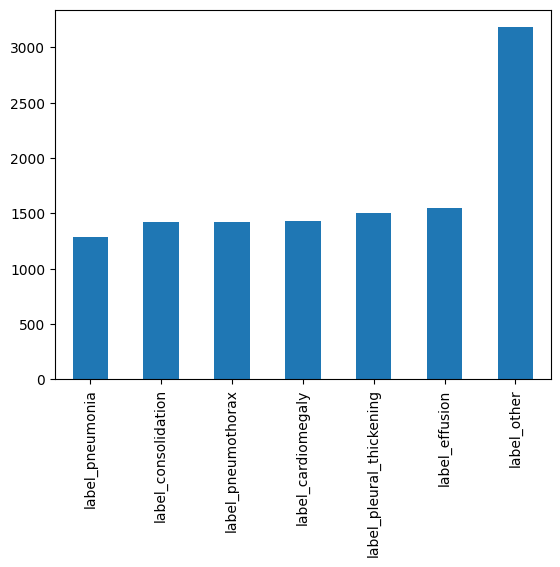

In [31]:
data_balanced[label_names].sum(axis=0).sort_values().plot(kind="bar");

We can use the remaining (i.e. not selected) data for our test set later on...

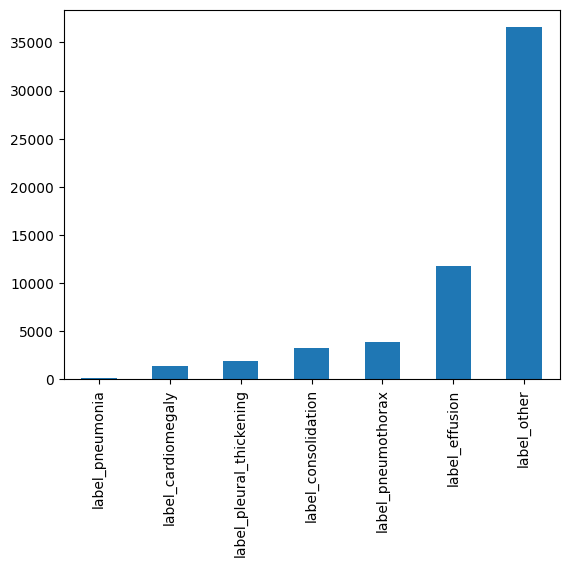

In [32]:
remaining_indices = data.index.difference(data_balanced.index)
remaining_data = data.loc[remaining_indices]
remaining_data[label_names].sum(axis=0).sort_values().plot(kind="bar");

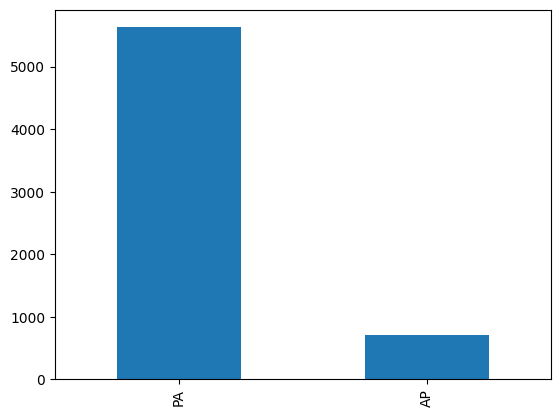

In [33]:
# TO DO: Try to prioritize Posterior-Anterior (PA) projection when building a balanced dataset
data_balanced.view_pos.value_counts().plot(kind="bar");

# Loading the Images

There are two ways to go about this:
1. Load the entire data set in memory if we have enough RAM, which we do. We estimate ~8000 images will take up between 4 to 8 gigabytes in RAM.
2. "Dataset generator": Keras has an "[image data generator](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)".

## Loading the Entire Dataset

Let's try the first method first...

In [34]:
import os
import pathlib

import numpy as np
import PIL

In [16]:
def load_img(img_filename):
    data_dir = pathlib.Path("../raw_data/images_224_224")
    image_filename = img_filename
    image = PIL.Image.open(pathlib.Path(data_dir, image_filename))
    return image

In [ ]:
n_images = data_balanced.shape[0]
example_img = load_img(data_balanced.iloc[0, :]["img_idx"])
img_dims = example_img.size
img_dims

In [ ]:
img_data = np.zeros((n_images, *img_dims))
img_data.shape

In [ ]:
# # This crashes Jupyter Notebook
# for img in data_balanced.loc[:, "img_idx"]:
#     # np.append(img_data, load_img(img))
#     pass

That was a dud. It crashes Jupyter Notebook. Let us now explore the second method.

## Generating the Dataset on the Fly

It turns out [`tf.keras.preprocessing.image.ImageDataGenerator`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator) is deprecated and hence not recommended for new code. Neither it nor its successor, [`tf.keras.utils.image_dataset_from_directory`](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) are really applicable to our multi-label problem. (They are suited to single-label classification problems). I found [this blog post](https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72) on how to leverage the underlying API, [`tf.data`](https://www.tensorflow.org/guide/data) for multi-label problems. Let us explore that.

In [35]:
import tensorflow as tf


In [36]:
# from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input

# In order to do 'transfer learning' using VGG16, ResNet, etc. our image needs to have three channels.
# We will simply duplicate the one grayscale channel 2 more times.
def expand_greyscale_image_channels(image):
    if image.shape[-1] == 1:
        grey_image_3_channel = tf.tile(image, tf.constant([1, 1, 3], tf.int32))
    else:
        grey_image_3_channel = image

    return preprocess_input(grey_image_3_channel)

In [38]:
IMG_SIZE = 224  # img_dims[0]
CHANNELS = 3  # The images WERE grayscale but we converted them to 3-channel


def parse_function(filename, label):
    """Function that returns a tuple of normalized image array and labels array.
    Args:
        filename: string representing path to image
        label: 0/1 one-dimensional array of size N_LABELS
    """
    # Read an image from a file
    image_string = tf.io.read_file(filename)
    # Decode it into a dense vector
    image_decoded = tf.image.decode_png(image_string, channels=CHANNELS)
    # Resize it to fixed shape
    image_resized = (
        image_decoded  # tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    )
    # Normalize it from [0, 255] to [0.0, 1.0]
    image_normalized = tf.cast(image_resized, tf.float32) # / 255.0 The scaling is taken care of by `preprocess_input()` above
    image_normalized_rgb = expand_greyscale_image_channels(image_normalized)
    label_tensor = tf.convert_to_tensor(label, dtype=tf.uint8)
    return image_normalized_rgb, label_tensor

In [39]:
cwd = os.getcwd()
data_dir = pathlib.Path(cwd, "..", "raw_data", "images_224_224")

# This works
img_norm_rgb, label_tensor = parse_function(
    str(pathlib.Path(data_dir, "00000009_000.png")),
    np.array([True, False, False, True]) + 0,
)
img_norm_rgb.shape

2023-02-25 07:35:48.772972: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 07:35:48.785124: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:116 : NOT_FOUND: /Users/nic/code/niccoulson/CXRay/notebooks/../raw_data/images_224_224/00000009_000.png; No such file or directory


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} /Users/nic/code/niccoulson/CXRay/notebooks/../raw_data/images_224_224/00000009_000.png; No such file or directory [Op:ReadFile]

In [40]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

img = mpimg.imread(pathlib.Path(data_dir, "00000009_000.png"))
plt.imshow(img, cmap="gray")
img.shape

FileNotFoundError: [Errno 2] No such file or directory: '/Users/nic/code/niccoulson/CXRay/notebooks/../raw_data/images_224_224/00000009_000.png'

In [41]:
BATCH_SIZE = 128  # The blog post suggested 256 is big enough to measure an F1-score but I suspect this was leading to this error while I was training the model: BiasGrad requires tensor size <= int32 max
AUTOTUNE = (
    tf.data.experimental.AUTOTUNE
)  # Adapt preprocessing and prefetching dynamically to reduce GPU and CPU idle time
SHUFFLE_BUFFER_SIZE = (
    512  # 1024  # Shuffle the training data by a chunck of 1024 observations
)

N_LABELS = len(label_names)

In [42]:
def create_dataset(filenames, labels, is_training=True):
    """Load and parse dataset.
    Args:
        filenames: list of image paths
        labels: numpy array of shape (BATCH_SIZE, N_LABELS)
        is_training: boolean to indicate training mode
    """

    # Create a first dataset of file paths and labels
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    # Parse and preprocess observations in parallel
    dataset = dataset.map(parse_function, num_parallel_calls=AUTOTUNE)

    if is_training == True:
        # This is a small dataset, only load it once, and keep it in memory.
        dataset = dataset.cache()
        # Shuffle the data each buffer size
        dataset = dataset.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE)

    # Batch the data for multiple steps
    dataset = dataset.batch(BATCH_SIZE)
    # Fetch batches in the background while the model is training.
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)

    return dataset

In [43]:
filenames = data_balanced.img_idx.to_list()
filepaths = [str(pathlib.Path(data_dir, filename)) for filename in filenames]
label_sets_binarized = np.array(
    data_balanced[label_names].apply(lambda x: x + 0), dtype=np.uint8
)

In [44]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train_bin, y_val_bin = train_test_split(
    filepaths, label_sets_binarized, test_size=0.2
)

In [45]:
train_ds = create_dataset(X_train, y_train_bin)
val_ds = create_dataset(X_val, y_val_bin)

We now, finally, have our training and validation data sets with the correct tensor sizes and data types.  
Now let's create the test set from the data that was _not_ selected while creating the balanced dataset. (Stored in `remaining_data`)

In [46]:
# Let's take a balanced subset...
test_data_balanced = remaining_data[remaining_data[rarest_label]]
n_min = test_data_balanced.shape[0]

for label, count in zip(label_counts_sorted.index[1:], label_counts_sorted[1:]):
    n_already_captured = test_data_balanced[test_data_balanced[label]].shape[0]
    n_additional = n_min - n_already_captured
    if n_additional > 0:
        not_selected_indices = remaining_data.index.difference(test_data_balanced.index)
        not_selected_data = remaining_data.loc[not_selected_indices]
        rows_to_add = not_selected_data[not_selected_data[label]].sample(n_additional)
        test_data_balanced = pd.concat([test_data_balanced, rows_to_add], axis=0)

test_data_balanced[label_names].sum(axis=0).sort_values()

label_pneumothorax          143
label_pneumonia             143
label_consolidation         145
label_cardiomegaly          146
label_pleural_thickening    148
label_effusion              156
label_other                 343
dtype: int64

In [ ]:
filenames_test = test_data_balanced.img_idx.to_list()
X_test = [str(pathlib.Path(data_dir, filename)) for filename in filenames_test]
y_test_bin = np.array(
    test_data_balanced[label_names].apply(lambda x: x + 0), dtype=np.uint8
)
test_ds = create_dataset(X_test, y_test_bin)

# Modelling

## Loss Function and Evaluation Metrics

The function below, from [the Medium post mentioned earlier](https://towardsdatascience.com/multi-label-image-classification-in-tensorflow-2-0-7d4cf8a4bc72), will provide our evaluation metric:

In [47]:
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)

    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive

    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2 * tp / (2 * tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

And the one below, from a related blog post ([here](https://towardsdatascience.com/the-unknown-benefits-of-using-a-soft-f1-loss-in-classification-systems-753902c0105d)), provides a differentiable version of the above, for our loss function:

In [48]:
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost.
    Average (1 - soft-F1) across all labels.
    Use probability values instead of binary predictions.

    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix of shape (BATCH_SIZE, N_LABELS)

    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """

    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2 * tp / (2 * tp + fn + fp + 1e-16)
    cost = 1 - soft_f1  # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost)  # average on all labels

    return macro_cost

## Baseline Model

What if we just returned ones across the board? (i.e. naively predict that all patients have all of the conditions)  
Or if we randomly predicted the conditions based on their frequencies of occurrence?  
We need _something_ to compare our eventual model's evaluation metrics to.  
Let us explore this further now.

### Naive baseline #1: All ones across the board

In [ ]:
pred_all_ones = np.ones(y_test_bin.shape)
macro_f1(y_test_bin, pred_all_ones)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_bin, pred_all_ones, target_names=label_names))

### Naive Baseline #2: Random based on frequency

In [ ]:
label_ratios = data_balanced[label_names].sum(axis=0) / len(data_balanced)
label_ratios

In [ ]:
pred_random_label_counts = round(y_test_bin.shape[0] * label_ratios)
pred_random_label_counts

In [ ]:
pred_random = np.zeros(y_test_bin.shape)

for i, label in enumerate(label_names):
    pred_random[
        np.random.choice(
            pred_random.shape[0], int(pred_random_label_counts[label]), replace=False
        ),
        i,
    ] = 1

# pred_random.sum(axis=0)
macro_f1(y_test_bin, pred_random)

In [ ]:
print(classification_report(y_test_bin, pred_random, target_names=label_names))

## Transfer Learning

We will be performing transfer learning using one of the many available pre-trained deep convolutional neural networks such as those listed in [this paper](https://www.nature.com/articles/s41598-020-70479-z.pdf?origin=ppubhttps://www.nature.com/articles/s41598-020-70479-z.pdf?origin=ppub).

In [ ]:
LR = 1e-5  # For transfer learning, use a small value such as 1e5
EPOCHS = 30


def get_pretrained_model():
    pretrained_model = tf.keras.applications.vgg16.VGG16( # tf.keras.applications.resnet50.ResNet50(
        include_top=False,
        input_shape=(IMG_SIZE, IMG_SIZE, CHANNELS),
    )
    pretrained_model.trainable = False
    return pretrained_model

In [ ]:
# pretrained = get_pretrained_model()
# pretrained.summary()

In [ ]:
def create_compiled_custom_model():
    base_model = get_pretrained_model()
    flattening_layer = tf.keras.layers.Flatten()
    dense_layer_1 = tf.keras.layers.Dense(250, activation="relu")
    dense_layer_2 = tf.keras.layers.Dense(100, activation="relu")
    dense_layer_3 = tf.keras.layers.Dense(50, activation="relu")
    prediction_layer = tf.keras.layers.Dense(N_LABELS, activation="sigmoid")

    model = tf.keras.models.Sequential(
        [
            base_model,
            flattening_layer,
            dense_layer_1,
            dense_layer_2,
            dense_layer_3,
            prediction_layer,
        ]
    )

    opt = tf.keras.optimizers.Adam(learning_rate=LR)

    model.compile(
        optimizer=opt,
        loss=macro_soft_f1,
        metrics=[macro_f1],
    )

    return model

In [ ]:
test_model = create_compiled_custom_model()
test_model.summary()

In [ ]:
# es = tf.keras.callbacks.EarlyStopping(
#     # monitor="val_macro_f1", mode="max", patience=5, verbose=1, restore_best_weights=True
#     monitor="val_loss",
#     mode="min",
#     patience=5,
#     verbose=1,
#     restore_best_weights=True,
# )
# history = test_model.fit(
#     train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1, callbacks=[es]
# )

In [ ]:
def plot_history(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    # --- LOSS: Soft Macro F1 ---
    ax[0].plot(history.history["loss"])
    ax[0].plot(history.history["val_loss"])
    ax[0].set_title("Loss")
    ax[0].set_ylabel("Soft Macro F1")
    ax[0].set_xlabel("Epoch")
    ax[0].legend(["Train", "Validation"], loc="best")
    ax[0].grid(axis="x", linewidth=0.5)
    ax[0].grid(axis="y", linewidth=0.5)

    # --- METRICS: Macro F1 ---

    ax[1].plot(history.history["macro_f1"])
    ax[1].plot(history.history["val_macro_f1"])
    ax[1].set_title("Metric")
    ax[1].set_ylabel("Macro F1")
    ax[1].set_xlabel("Epoch")
    ax[1].legend(["Train", "Validation"], loc="best")
    ax[1].grid(axis="x", linewidth=0.5)
    ax[1].grid(axis="y", linewidth=0.5)

    return ax

In [ ]:
plot_history(history);

In [ ]:
res = test_model.evaluate(test_ds, return_dict=True)
res

In [ ]:
import pickle

filename = "test.pkl"
# pickle.dump(test_model, open(filename, "wb"))

loaded_model = pickle.load(open(filename, "rb"))

In [ ]:
y_pred = []  # store predicted labels
y_true = []  # store true labels

# iterate over the dataset
for image_batch, label_batch in dataset:   # use dataset.unbatch() with repeat
   # append true labels
   y_true.append(label_batch)
   # compute predictions
   preds = model.predict(image_batch)
   # append predicted labels
   y_pred.append(np.argmax(preds, axis = - 1))

# convert the true and predicted labels into tensors
correct_labels = tf.concat([item for item in y_true], axis = 0)
predicted_labels = tf.concat([item for item in y_pred], axis = 0)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, target_names=labels))